In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

In [5]:
def diffyqs(X, t, omega0_2):
    xdot,x = X
    dx = xdot
    dv = -omega0_2*x
    return [dv, dx]

def analytic_sol_noisy(t,omega0,initial_condition,noise_sigma):
    v0,x0 = initial_condition
    return (v0/omega0)*np.sin(omega0*t) + x0 * np.cos(omega0*t) +  noise_sigma * np.random.randn(len(t))

def analytic_sol(t,omega0,initial_condition):
    v0,x0 = initial_condition
    return (v0/omega0)*np.sin(omega0*t) + x0 * np.cos(omega0*t)

def analytic_sol_fancy(t,omega0,initial_condition):
    v0, x0 = initial_condition
    return x0/np.cos(np.arctan(v0/(omega0 * x0))) * np.cos(omega0 * t - np.arctan(v0/(omega0 * x0)))

def log_likelihood(theta):
    omega0 = theta
    if omega0 == 0.0:
        omega0 = 0.01
    else:
        pass
    sol = analytic_sol(t,omega0,initial_condition)
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol - x_true)**2)

1.0 1.0


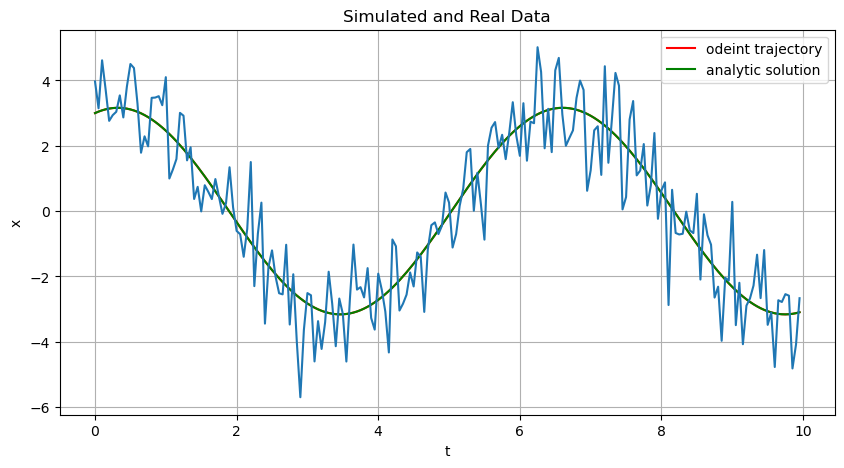

In [6]:
initial_condition = [1, 3]

k = 1
m = 1
omega0 = np.sqrt(k/m)
omega0_2 = k/m
print(omega0,omega0_2)
t = np.arange(0,10,0.05)
sigma = 0.1
sol_numerical = odeint(diffyqs, initial_condition, t, args=(omega0_2,)) # pass odeint the differential equation, initial condition, time array, and parameters
sol_analytic = analytic_sol(t,omega0,initial_condition)
#sol_analytic_fancy = analytic_sol_fancy(t,omega0,initial_condition)
sol_analytic_noisy = analytic_sol_noisy(t,omega0,initial_condition,1.0)
x_true = sol_analytic
# plot plot plot
plt.figure(figsize=(10,5))
plt.plot(t,sol_numerical[:,1], label = 'odeint trajectory',c = 'r') # to get the right part of the solution you have to do this weird transpose index thing
plt.plot(t,sol_analytic, label = "analytic solution", c = 'g')
#plt.plot(t,sol_analytic_fancy, label = "analytic solution", c = 'b')
plt.plot(t,sol_analytic_noisy)
plt.title('Simulated and Real Data')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()

In [7]:
D = 1  

LB = np.full((1, D), 0.0)  # Lower bounds
UB = np.full((1, D), 100.0)  # Upper bounds

PLB = np.copy(LB)
PUB = np.copy(UB) 
PUB[0][0] =  10.0
PLB[0][0] = 0.1

x0 = 1.2 * np.ones((1, D))

options = {
    "max_fun_evals": 100,
    "display": "iter"
}

print(options)
print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0)

{'max_fun_evals': 100, 'display': 'iter'}
LB: [[0.]] PLB: [[0.1]] PUB: [[10.]] UB: [[100.]] x0: [[1.2]]


In [39]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = SplineTrapezoidal(LB, PLB, PUB, UB), options = options) # initialize VMBC object

vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10        -695.97      1242.70   1263365.52        2        inf     start warm-up
     1         15       -1391.99       263.41      1958.81        2        inf     
     2         20       -2041.47       231.57       588.06        2   2.25e+04     
     3         25       -2318.33       241.91     18195.84        2   6.08e+05     
     4         30        -134.72       354.72     26475.89        2   8.91e+05     
     5         35        -233.15         0.01         7.17        2        567     
     6         40        -233.14         0.00         0.00        2     0.0622     
     7         45        -233.15         0.00         0.00        2      0.128     
     8         50        -233.15         0.00         0.01        2      0.253     
     9         55        -233.14         0.00         0.01        2      0.245     
    10         60        -233.15         0.00         0.00        2     0.0505     end warm-up
    11         65        -233.16         0.00       

In [24]:
# f_counts = [200]

# for f_count in f_counts:
#     options["max_fun_evals"] = f_count
#     print(options["max_fun_evals"])
#     vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = SplineTrapezoidal(LB, PLB, PUB, UB), options = options) # initialize VMBC object

#     vp, results = vbmc.optimize() # do optimization (might take a while)
#     vp.save("vp_" + str(f_count) + ".pkl",overwrite = True)

In [25]:
# vps = []
# f_counts = [50,100,150,200]
# from pyvbmc import VariationalPosterior
# for f_count in f_counts:
#     vps.append(VariationalPosterior.load("vp_" + str(f_count) + ".pkl"))

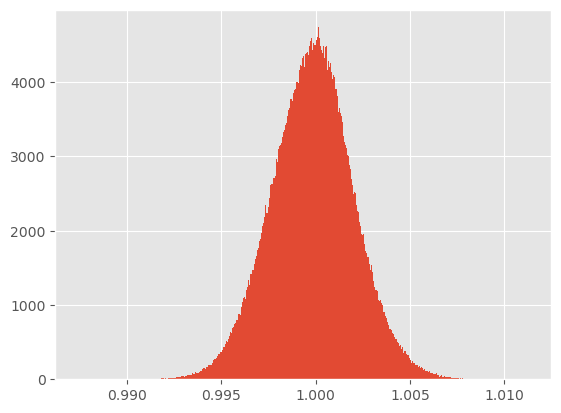

In [40]:
from pyvbmc import VariationalPosterior
#vp = VariationalPosterior.load("sho_toy.pkl")

Xs, _ = vp.sample(int(1e6))
#plt.plot(t,sol_analytic, label = "analytic solution", c = 'g')
plt.hist(Xs.T[0], bins = 1000)
plt.show()

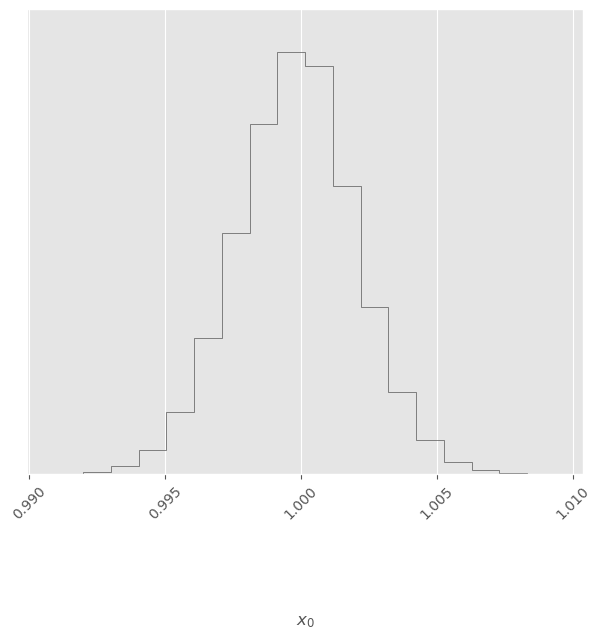

In [41]:
vp.plot();

In [42]:
moment = vp.moments()[0]

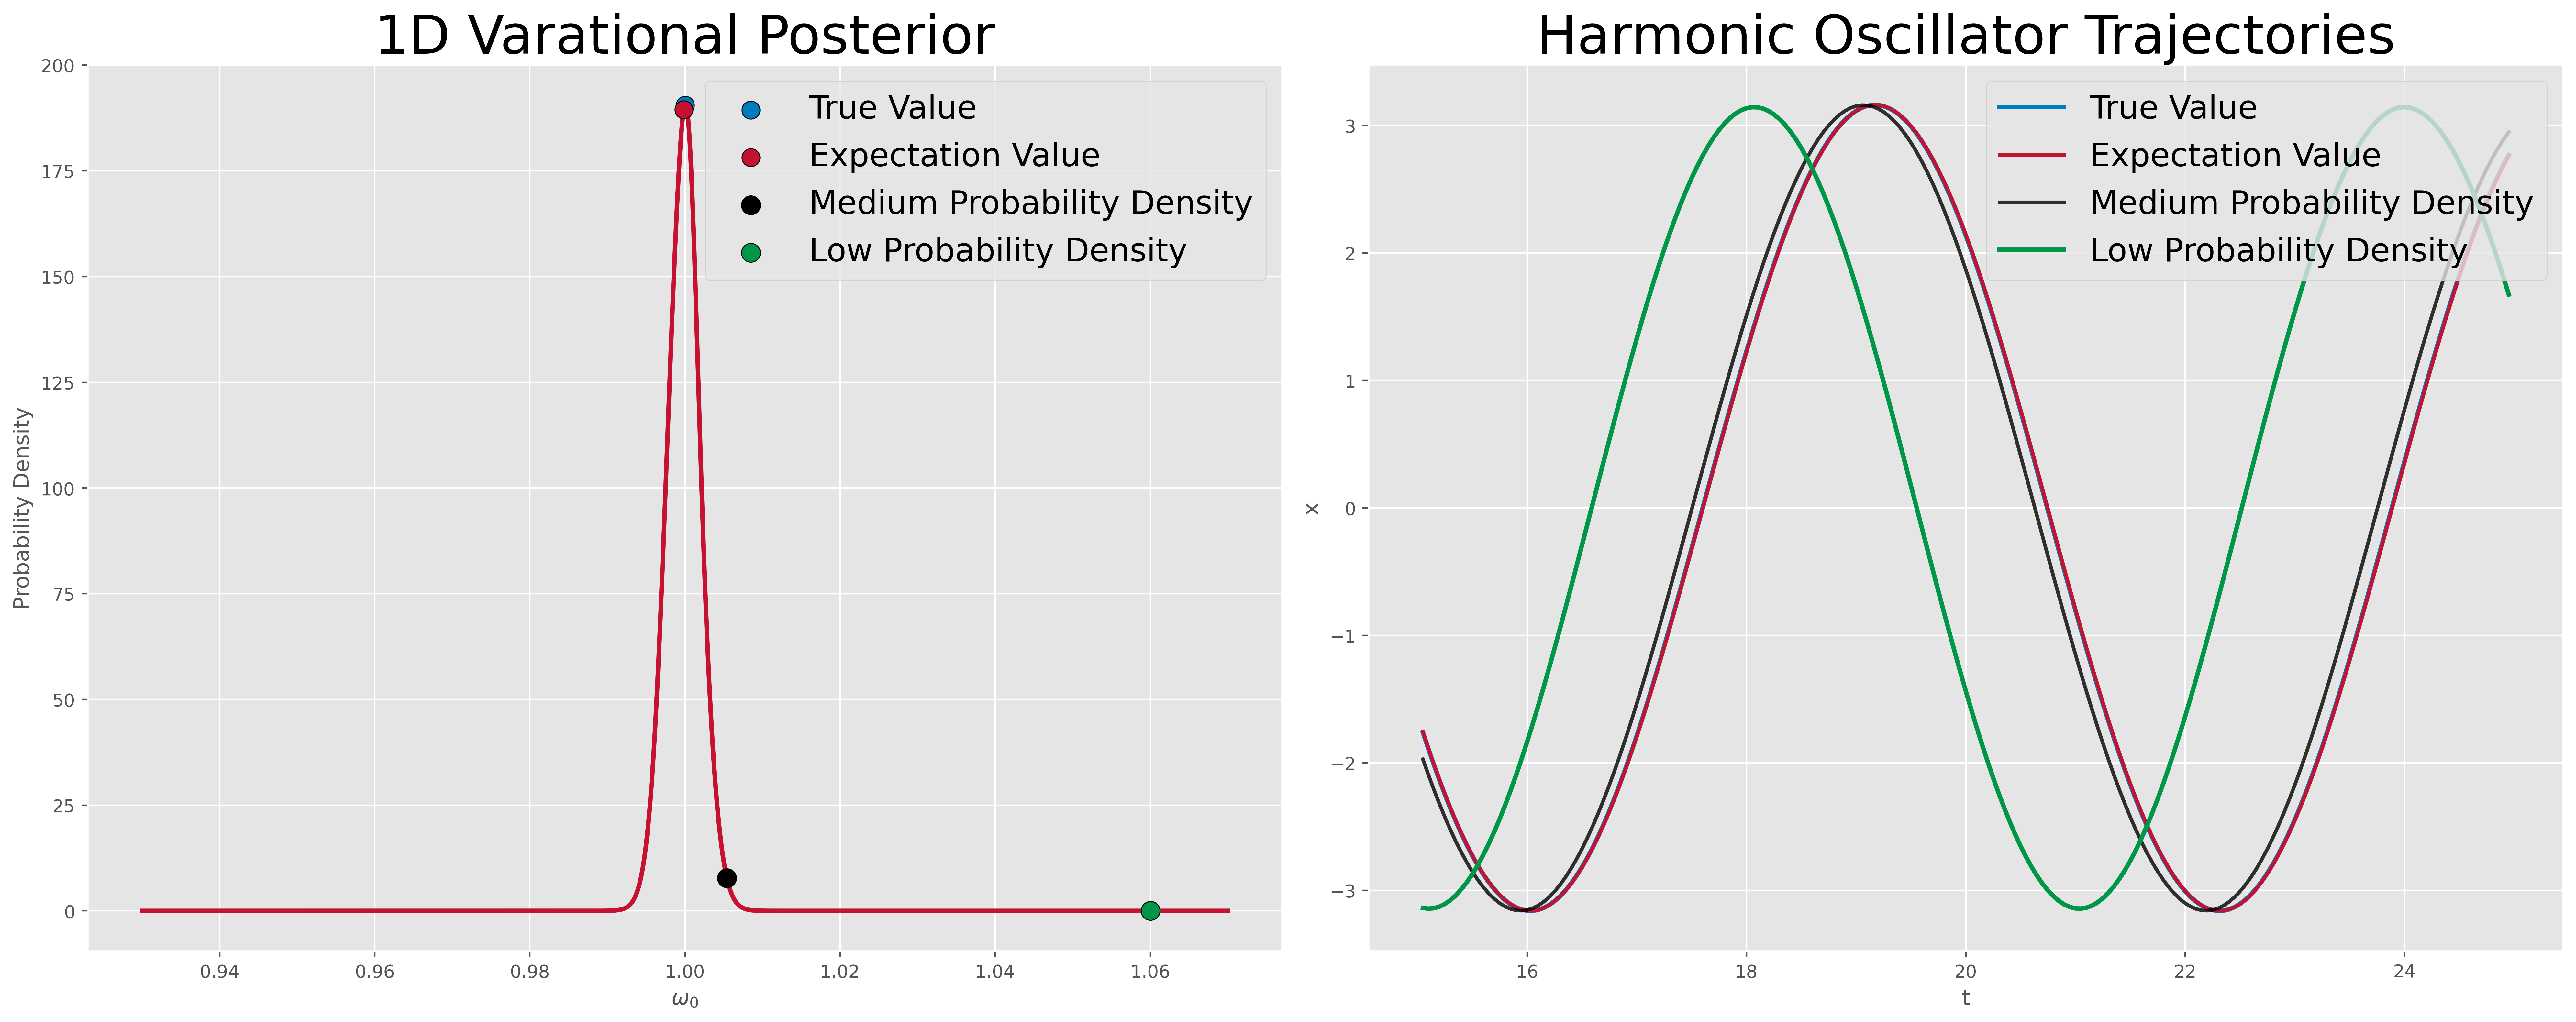

In [48]:
# sols = []
# sigma = 0.25
# omegas = np.arange(0,3,0.01)
# for omega in omegas:
#     sols.append(log_likelihood(omega))

t = np.arange(0,25,0.05)
mask = t>15
dx = 0.07
wos = np.arange(1-dx,1 + dx,0.0001)
moments = vp.moments()
low_pdf_w0 = 1.06
med_w0 = 1.0054
sol_analytic2 = analytic_sol(t,low_pdf_w0,initial_condition)
expect_traject = analytic_sol(t,moment,initial_condition)
med_trajcectory = analytic_sol(t,med_w0,initial_condition)
# we'll use ggplot style for now
plt.style.use("ggplot")
# use red first, then blue then green for single plots
red = "#C41230"
blue  = "#007BC0"
green = "#009647"
gold = "#FDB515"
gray = "#6D6E71"
teal = "#008F91"
fig, axs = plt.subplots(1, 2, figsize = (20,8),dpi = 400)
axs = axs.ravel()
no_noise_sol = analytic_sol(t,1.,initial_condition)
axs[1].plot(t[mask],no_noise_sol[mask], label = "True Value", c = blue,lw = 2.5)
axs[1].plot(t[mask],expect_traject[mask], label = "Expectation Value", c = red, lw = 2.)
axs[1].plot(t[mask],med_trajcectory[mask], label = "Medium Probability Density", c = "black", lw = 2,alpha = 0.8)
axs[1].plot(t[mask],sol_analytic2[mask], label = "Low Probability Density", c = green, lw = 2.5)

axs[1].set_title("Harmonic Oscillator Trajectories", fontsize = 30)
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
axs[1].legend(loc = "upper right",fontsize = 18)

# axs[1].plot(omegas,sols, c = red)
# axs[1].set_ylim(-40000,4000)
# axs[1].set_title("Log Likelihood")
# axs[1].set_xlabel(r"$\omega_0$")
# axs[1].set_ylabel(r"$\log P (\mathbf{x}_{true}|\omega_0)$")

#axs[0].plot(wos,vps[3].pdf(wos.reshape(-1,1)), label = "LL Evalutations : 200",c = red)
axs[0].plot(wos,vp.pdf(wos.reshape(-1,1)), c = red,lw = 2.5,zorder = 1)
axs[0].scatter(1.0,vp.pdf(1.0),c = blue, s = 100, label="True Value",edgecolor='black')
axs[0].scatter(moments,vp.pdf(moments),c = red, s = 100, label="Expectation Value",edgecolor='black')
axs[0].scatter(med_w0,vp.pdf(med_w0),c = "black", s = 110, label = "Medium Probability Density")
axs[0].scatter(low_pdf_w0,vp.pdf(low_pdf_w0),c = green, s = 110, label = "Low Probability Density",edgecolor='black')

axs[0].set_title("1D Varational Posterior",fontsize = 30)
axs[0].set_xlabel(r"$\omega_0$")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc = "upper right",fontsize = 18)
plt.tight_layout()

plt.show()

In [61]:
options2 = {
    "max_fun_evals": 90
}

vbmc2 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB), options = options2) # initialize VMBC object

vp2, results2 = vbmc2.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


KeyboardInterrupt: 

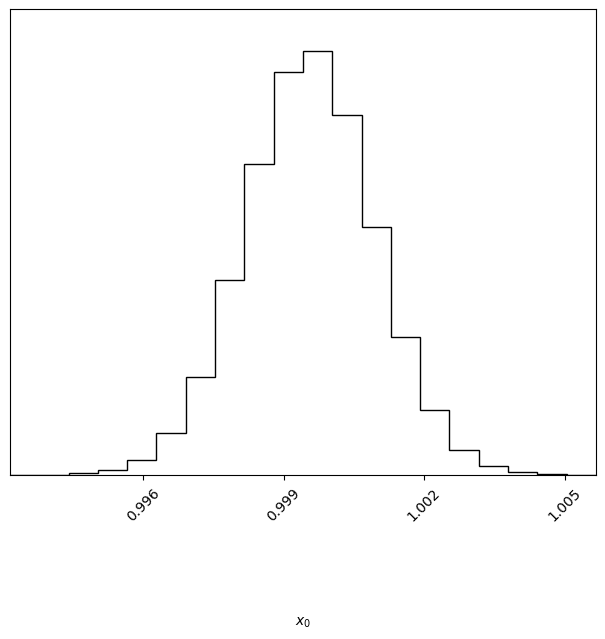

In [45]:
vp2.plot();

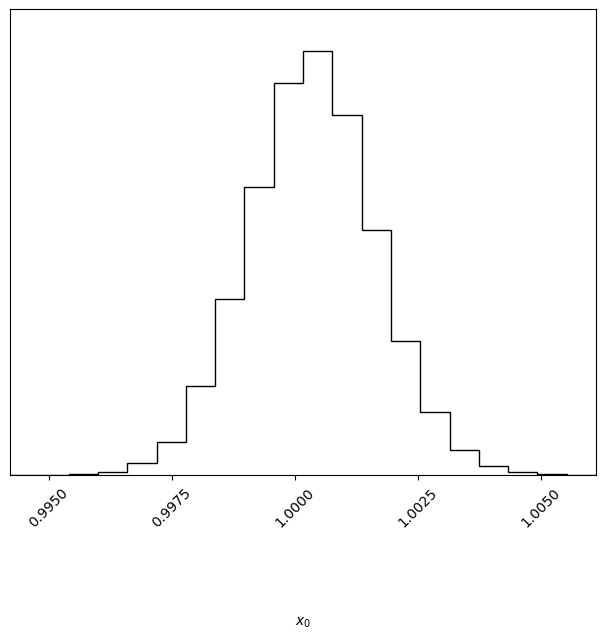

In [319]:
vp2.plot();

In [331]:
true_posterior = scs.multivariate_normal(mean = np.array([1.0]), cov = np.array([sigma_small]))
## These adapted from PyVBMC source code
def truth_first_KL_1D(true_posterior,vp2, N = int(1e4)):  # KL[true posterior || vp2]
    truth_samples = true_posterior.rvs(size = N)
    truth_densities = true_posterior.pdf(truth_samples)
    vp2_samples = vp2.pdf(truth_samples.reshape((-1,1))) # NEED TO DO RESHAPE FOR 1D
    truth_densities[truth_densities == 0 | np.isinf(truth_densities)] = 1.0
    vp2_samples[vp2_samples == 0 | np.isinf(vp2_samples)] = minp
    KL = -np.mean(np.log(vp2_samples) - np.log(truth_densities))
    return np.maximum(0, KL)

print(truth_first_KL_1D(true_posterior,vp2))

from pyvbmc.stats import kl_div_mvn
N = int(1e5)
truth_densities_mu, truth_densities_sigma = np.atleast_2d(true_posterior.mean), true_posterior.cov
vp2_samples_mu, vp2_samples_sigma = vp2.moments(N,orig_flag=True, cov_flag=True)

kls = kl_div_mvn(truth_densities_mu, truth_densities_sigma, vp2_samples_mu, vp2_samples_sigma) # ASSUMES NORMAL DISTRIBUTION

print(kls[0])


22.01133477703462
27.993488545095417


In [334]:
from scipy.special import rel_entr

def dirac_delta(x,a=0, sigma = 0.01):
    return 1/(sigma* (2*np.pi)**0.5) * np.exp(-0.5 * (x-a)**2 / sigma**2)

x = np.arange(-10,10,0.01).reshape(-1,1)
np.sum(rel_entr(vp.pdf(x), vp2.pdf(x)))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 2

In [335]:
x = np.arange(-10,10,0.01).reshape(-1,1)
sigma_small = 0.001
print("KL[vp1 pdf || delta]:", np.sum(rel_entr(vp.pdf(x), dirac_delta(x,1,sigma_small))), \
      "\nKL[delta|| vp1 pdf ]:",np.sum(rel_entr(dirac_delta(x,1,sigma_small),vp.pdf(x))))
print("KL[vp2 pdf || delta]:", np.sum(rel_entr(vp2.pdf(x), dirac_delta(x,1,sigma_small))), \
      "\nKL[delta || vp2 pdf]:",np.sum(rel_entr(dirac_delta(x,1,sigma_small),vp2.pdf(x))))
print("KL[vp1 pdf || vp2 pdf]:",np.sum(rel_entr(vp.pdf(x), vp2.pdf(x))), \
      "\nKL[vp2 pdf || vp1 pdf]:", np.sum(rel_entr(vp2.pdf(x),vp.pdf(x))))
print("KLs of vp1 and vp2 from vp method",vp.kl_div(vp2,N))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 2

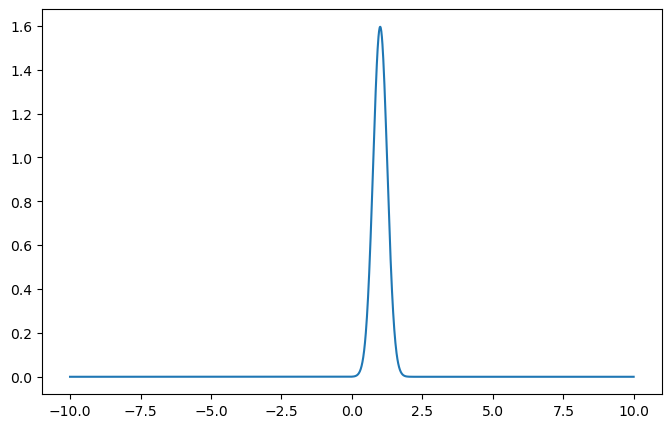

In [169]:
plt.figure(figsize=(8,5))
plt.plot(x,dirac_delta(x,1,sigma_small), label = "'dirac delta'")
plt.plot(x,vp.pdf(x), label = "vp1 pdf")
plt.plot(x,vp2.pdf(x), label = "vp2 pdf")
plt.legend(loc = "lower right")
plt.xlim(0.5,1.5)
plt.show()

In [75]:
N = int(1e5)
q1mu, q1sigma = vp.moments(N,orig_flag=True, cov_flag=True)
q2mu, q2sigma = vp2.moments(N,orig_flag=True, cov_flag=True)

kls = kl_div_mvn(q1mu, q1sigma, q2mu, q2sigma) # ASSUMES NORMAL DISTRIBUTION

print(kls)
print(np.maximum(0, kls))
print(vp.kl_div(vp2,N))

[0.08628235 0.11331324]
[0.08628235 0.11331324]
[0.09331619 0.13969409]


In [98]:
from numpy import sin
from scipy import stats
class your_distribution(stats.rv_continuous):
    def _pdf(self, x):
        sigma = 1
        mu = 0
        return 1/(sigma * (2 * np.pi)** 0.5 ) * np.exp(-0.5 * ((x-mu)/sigma)**2)

distribution = your_distribution()
samples = distribution.rvs(size = 1000)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1

make 3d vp plots

threshold threshold

check with true bimodal distribution

In [ ]:
def pdf_kl_div():
    minp = sys.float_info.min
    xx1, _ = vp.sample(N, True, True)
    q1 = vp.pdf(xx1, True)
    q2 = vp2.pdf(xx1, True)
    q1[q1 == 0 | np.isinf(q1)] = 1.0
    q2[q2 == 0 | np.isinf(q2)] = minp
    kl1 = -np.mean(np.log(q2) - np.log(q1))

    xx2, _ = vp2.sample(N, True, True)
    q1 = vp.pdf(xx2, True)
    q2 = vp2.pdf(xx2, True)
    q1[q1 == 0 | np.isinf(q1)] = minp
    q2[q2 == 0 | np.isinf(q2)] = 1.0
    kl2 = -np.mean(np.log(q1) - np.log(q2))
    kls = np.concatenate((kl1, kl2), axis=None)

# Correct for numerical errors
kls = np.maximum(0, kls)

best choice for omega_0: 1.0


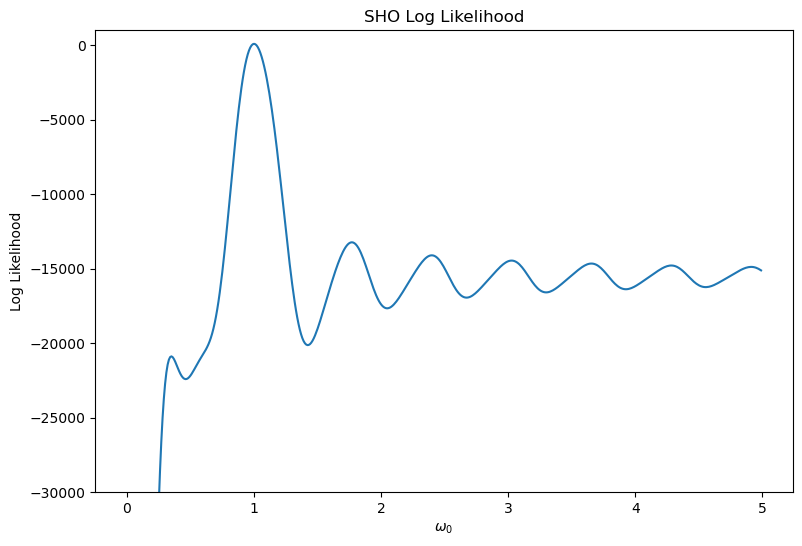

In [20]:
sols = []
sigma = 0.25
omegas = np.arange(0,5,0.01)
for omega in omegas:
    sols.append(log_likelihood(omega))
print("best choice for omega_0:",omegas[np.argmax(np.array(sols))])
plt.figure(figsize=(9,6))
plt.plot(omegas,sols)
plt.title("SHO Log Likelihood")
plt.ylim(-30000,1000)
plt.xlabel(r"$\omega_0$")
plt.ylabel("Log Likelihood")
plt.show()

best choice for a: 1.0


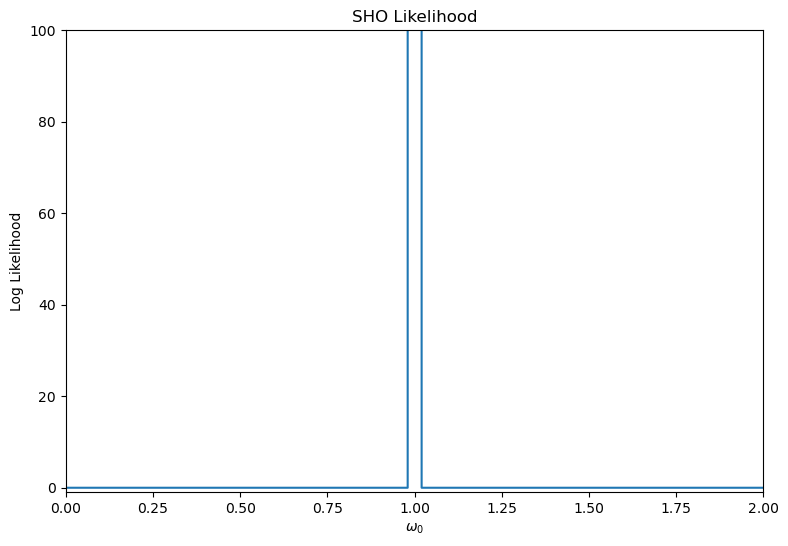

In [11]:
sols = []
sigma = 0.25
omegas = np.arange(0,5,0.01)
for omega in omegas:
    sols.append(np.exp(log_likelihood(omega)))
print("best choice for a:",omegas[np.argmax(np.array(sols))])
plt.figure(figsize=(9,6))
plt.plot(omegas,sols)
plt.title("SHO Likelihood")
plt.ylim(-1,100)

plt.xlim(0,2)
plt.xlabel(r"$\omega_0$")
plt.ylabel("Log Likelihood")
plt.show()

In [101]:
def log_likelihood(theta):
    omega0,x0 = theta
    if omega0 == 0.0:
        omega0 = 0.01
    else:
        pass
    initial_condition = [1,x0]
    sol = analytic_sol(t,omega0,initial_condition)
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol - x_true)**2)

D = 2

LB = np.full((1, D), -1000.0)  # Lower bounds
UB = np.full((1, D), 1000.0)  # Upper bounds
LB[0][0] = 0.0

PUB = np.copy(UB) 
PUB[0][0] = 10.0
PUB[0][1] = 10.0
PLB = np.copy(LB)
PLB[0][0] = 0.9
PLB[0][1] = -10.0

x0 = 3 * np.ones((1, D))

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0)

LB: [[    0. -1000.]] PLB: [[  0.9 -10. ]] PUB: [[10. 10.]] UB: [[1000. 1000.]] x0: [[3. 3.]]


In [102]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -5876.44      1061.73  39611038.35        2        inf     start warm-up
     1         15       -2934.51       598.01      2573.76        2        inf     
     2         20        -223.15       136.71      4275.92        2    1.1e+05     
     3         25          70.31         0.73       217.52        2   6.11e+03     
     4         30          70.53         0.00         0.01        2      0.903     
     5         35          70.57         0.00         0.00        2      0.186     
     6         40          70.55         0.00         0.01        2      0.259     
     7         45          70.53         0.00         0.01        2      0.367     
     8         50          7

[[1.00001015 2.9995936 ]] 1.0 3


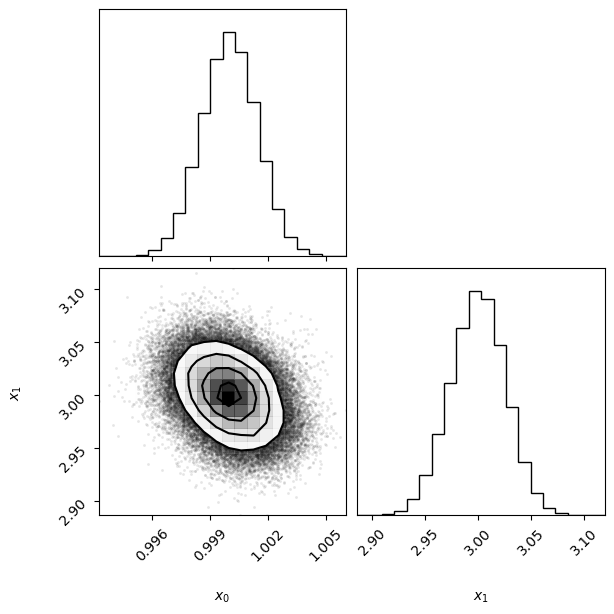

In [106]:
vp.plot();
print(vp.moments(), omega0,3)

# 2 BODY PROBLEM

In [172]:
def two_body_analytic_sol(phi,m,alpha,L,A,phi0):
    return 1 / (m * alpha / L**2 + A * np.cos(phi - phi0))

def two_body_log_likelihood(theta):
    A = theta
    sol = two_body_analytic_sol(phi,m,alpha,L,A,phi0)
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol - r_true)**2)

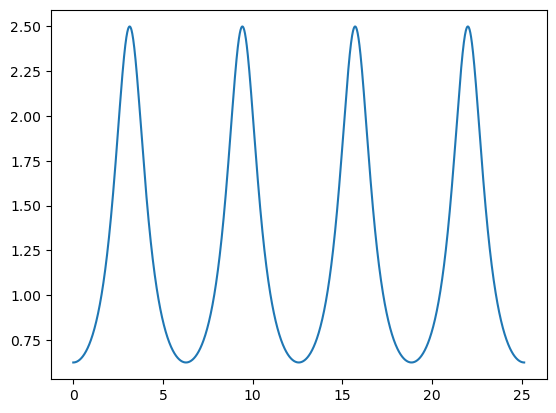

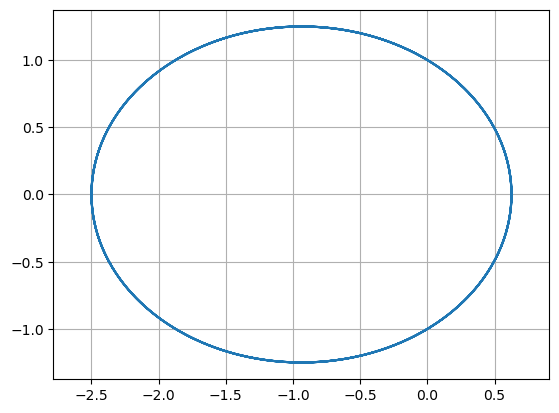

In [173]:
phi = np.arange(0,4* 2*np.pi,0.01)
m = 1
alpha = 1
L = 1
A = 0.6
phi0 = 0


r_true = two_body_analytic_sol(phi,m,alpha,L,A,phi0)

plt.plot(phi,r_true)
plt.show()
plt.plot(r_true * np.cos(phi), r_true * np.sin(phi))
plt.grid()
plt.axis("equal")
plt.show()

In [203]:
As = np.arange(0,0.9,0.01)
sigma = 0.01
m = 1
alpha = 1
L = 1
A = 0.6
B = 10
phi0 = 0
sigma = 0.05


def two_body_analytic_sol(phi,A,B,phi0 = 0):
    return 1 / (B + A * np.cos(phi - phi0))

r_true = two_body_analytic_sol(phi,A,B,phi0)

def two_body_log_likelihood(theta):
    A, B = theta
    sol = two_body_analytic_sol(phi,A,B,phi0)
    return np.sum(np.log(1/(sigma * (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol - r_true)**2)


D = 2
LB = np.full((1, D), 0.001)  # Lower bounds
UB = np.full((1, D), 100.0)  # Upper bounds
LB[0][0] = 0.0
LB[0][1] = 1.0
UB[0][0] = 0.99

PUB = np.copy(UB) 
PUB[0][0] = 0.9
PUB[0][1] = 30.0
PLB = np.copy(LB)
PLB[0][0] = 0.1
PLB[0][1] = 2.0

x0 = 3 * np.ones((1, D))
x0[0][0] = 0.4
#prior = SplineTrapezoidal(LB, PLB, PUB, UB)
print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0)

LB: [[0. 1.]] PLB: [[0.1 2. ]] PUB: [[ 0.9 30. ]] UB: [[  0.99 100.  ]] x0: [[0.4 3. ]]


In [204]:
vbmc = VBMC(two_body_log_likelihood, x0, LB, UB, PLB, PUB, prior = SplineTrapezoidal(LB, PLB, PUB, UB) ) # initialize VMBC object

two_body_vp1, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10        9185.09     18286.59 1323829174634.64        2        inf     start warm-up
     1         15        6482.32      3828.49     24506.92        2        inf     
     2         20        5579.81      2285.28      1611.20        2   4.86e+04     
     3         25        5215.65        10.81       496.31        2   1.29e+04     
     4         30        5213.03         0.16         0.22        2       14.4     
     5         35        5270.26       109.82     19745.54        2   4.66e+05     
     6         40        5362.39       116.92        30.04        2    1.4e+03     
     7         45        5214.76         0.24     37788.63        2   8.91e+05     


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


     8         50        5214.74         0.18         0.06        2       2.09     


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 7. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 6. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


     9         55        5214.56         0.02         0.09        2       2.82     


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    10         60        5214.55         0.02         0.01        2       0.25     end warm-up


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    11         65        5214.50         0.03         0.02        2      0.676     
    12         70        5214.55         0.01         0.01        2       0.46     
    13         75        5214.57         0.00         0.00        5      0.152     
    14         80        5214.57         0.00         0.00        8     0.0787     rotoscale, undo rotoscale
    15         85        5214.59         0.00         0.00       11      0.074     
    16         90        5214.58         0.00         0.00       13     0.0616     
    17         95        5214.57         0.00         0.00       13     0.0453     
    18        100        5214.57         0.00         0.00       13     0.0382     
    19        105        5214.57         0.00         0.00       13     0.0363     stable
   inf        105        5214.57         0.00         0.00       50     0.0363     finalize
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 5214.570 

In [207]:
options = {
    "max_fun_evals": 90
}

x0 = 8 * np.ones((1, D))
x0[0][0] = 0.7

vbmc = VBMC(two_body_log_likelihood, x0, LB, UB, PLB, PUB, prior = SplineTrapezoidal(LB, PLB, PUB, UB), options = options) # initialize VMBC object

two_body_vp2, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10        5239.43      1155.25          inf        2        inf     start warm-up
     1         15        5214.50         0.47         1.32        2        inf     
     2         20        5214.56         0.00         0.06        2       1.73     
     3         25        5214.58         0.01         0.01        2       0.31     
     4         30        5214.59         0.00         0.00        2     0.0674     
     5         35        5214.57         0.00         0.00        2      0.125     
     6         40        5214.55         0.00         0.01        2      0.288     end warm-up
     7         45        5214.59         0.00         0.01        2       0.34     
     8         50        5214.57         0.00         0.00        2      0.113     
     9         55        5214.58         0.00         0.00        5     0.0908     
    10         60        5214.59         0.00         0.00        8     0.0732     rotoscale, undo rotoscale
    11         65        52

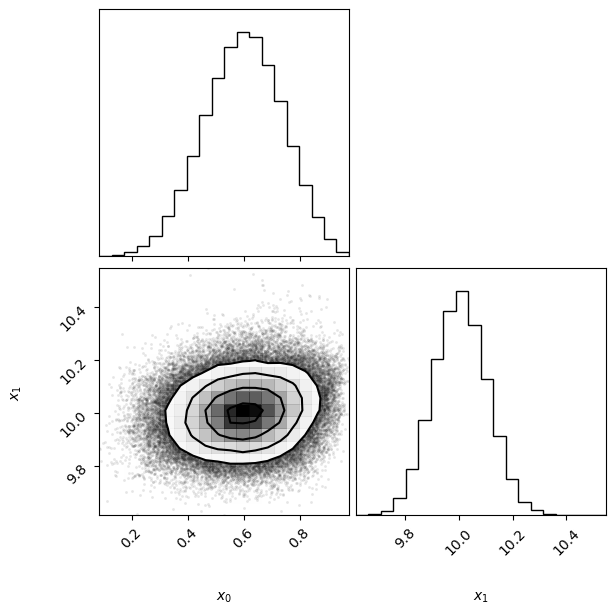

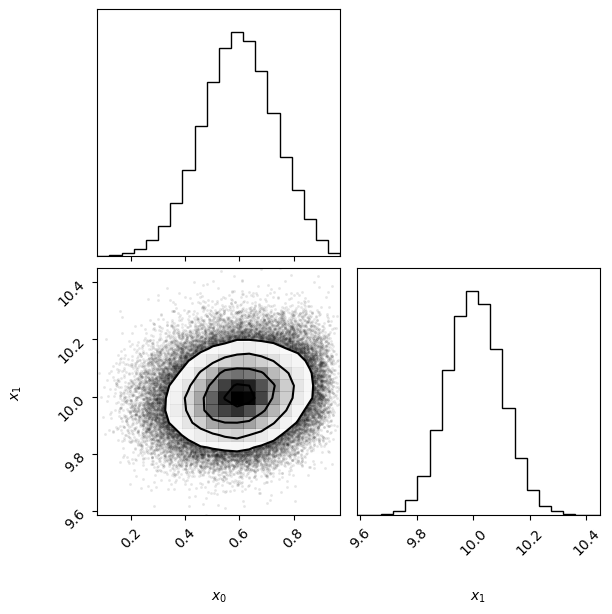

In [208]:
two_body_vp1.plot();
two_body_vp2.plot();

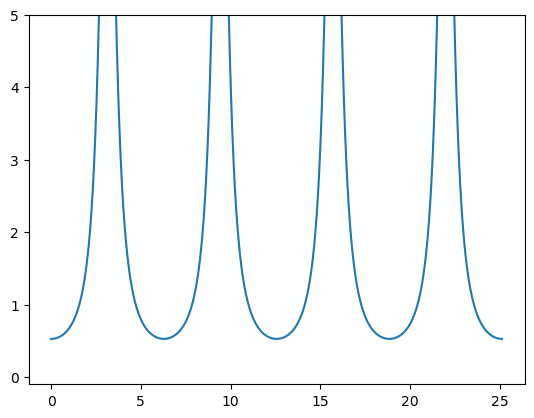

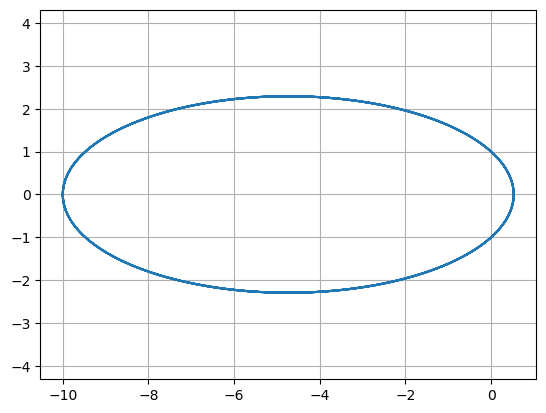

In [154]:
A = 0.9
B = 1
r = two_body_analytic_sol(phi,A,B,phi0)

plt.plot(phi,r)
plt.ylim(-0.1,5)
plt.show()
plt.plot(r * np.cos(phi), r * np.sin(phi))
plt.grid()
plt.axis("equal")
plt.show()